# Elliptical Slice Sampling
The purpose of this notebook is to check if the `elliptic.py` file implementing Elliptical Slice Sampling works as expected, whilst demonstrating how it can be used to sample from the latent variable posterior $p(\mathbf{f} | \mathbf{y}, \boldsymbol{\theta})$.

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from gproc.elliptic import ess_samples_probit
from gproc.generative import sample_at_x
from gproc.kernels import squared_exponential
from gproc.kernels import rational_quadratic
from gproc.kernels import periodic

## Data Generation

In [2]:
N = 500 # Data size
D = 1 # Data dimension

x = np.random.uniform(-1, 1, N * D).reshape(-1, D) # Reshape to N x D matrix
y, prob_y, f = sample_at_x(x, kernel_fcn=periodic, kernel_params = {'lengthscale': 1, 'variance': 1.4, 'period':2})

## Generate Latent Posterior Samples

In [3]:
model_lengthscale=0.1
model_variance=1.4
#K = squared_exponential(x, x, lengthscale=model_lengthscale, variance=model_variance)
#K = rational_quadratic(x, x, lengthscale=0.1, variance=1.4, weighting=1)
K = periodic(x, x, lengthscale=1, variance=1.4, period=2)
K_chol = np.linalg.cholesky(K + 0.0001*np.eye(K.shape[0]))
samples = ess_samples_probit(K_chol, y, 2500, 500 , verbose=True)

## Mean of Samples Against True Function and Laplace

### ESS Samples Mean

In [4]:
ess_mean = np.mean(samples, axis=0)

### Laplace Approximation

In [5]:
from gproc.laplace import laplace_approximation_probit, chol_inverse

laplace_mean, df_ll, laplace_cov, objective_history, converged = laplace_approximation_probit(y, chol_inverse(K))

In [6]:
laplace_samples = np.random.multivariate_normal(laplace_mean, laplace_cov, 2500)

## Plot Means

In [7]:
ess_mean.shape

(500,)

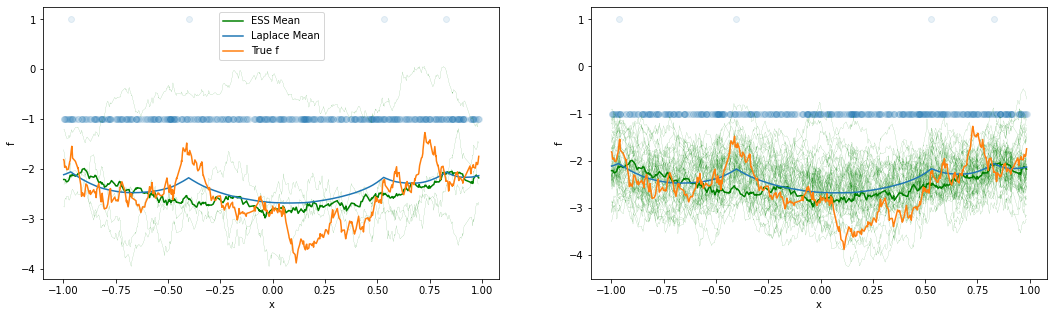

In [8]:
sort_ix = np.argsort(x.reshape(-1))

fig, axarr = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [1,1]})

axarr[0].scatter(x, y, alpha=0.1)
axarr[0].set_xlabel('x')
axarr[0].set_ylabel('f')

for i in range(0, samples.shape[0], 50):
    axarr[0].plot(x[sort_ix], samples[i, sort_ix], c = 'g', linewidth = 0.1)

axarr[0].plot(x[sort_ix], ess_mean[sort_ix], c='g', label='ESS Mean')
axarr[0].plot(x[sort_ix], laplace_mean[sort_ix], label='Laplace Mean')
axarr[0].plot(x[sort_ix], f[sort_ix], label='True f')

axarr[0].legend()

axarr[1].scatter(x, y, alpha=0.1)
axarr[1].set_xlabel('x')
axarr[1].set_ylabel('f')

for i in range(0, laplace_samples.shape[0], 50):
    axarr[1].plot(x[sort_ix], laplace_samples[i, sort_ix], c = 'g', linewidth = 0.1)

axarr[1].plot(x[sort_ix], ess_mean[sort_ix], c='g', label='ESS Mean')
axarr[1].plot(x[sort_ix], laplace_mean[sort_ix], label='Laplace Mean')
axarr[1].plot(x[sort_ix], f[sort_ix], label='True f')
axarr[0].legend()

(array([ 4.,  4.,  4.,  1.,  2.,  2.,  4.,  3.,  7., 11., 11.,  7.,  9.,
        10., 15., 10.,  9., 10., 11., 12.,  7.,  4.,  9.,  2.,  5.,  5.,
         1.,  3.,  1.,  2.,  1.,  2.,  2.,  2.,  2.,  0.,  1.,  1.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([-2.84427012, -2.79963152, -2.75499292, -2.71035432, -2.66571573,
        -2.62107713, -2.57643853, -2.53179993, -2.48716133, -2.44252274,
        -2.39788414, -2.35324554, -2.30860694, -2.26396834, -2.21932974,
        -2.17469115, -2.13005255, -2.08541395, -2.04077535, -1.99613675,
        -1.95149816, -1.90685956, -1.86222096, -1.81758236, -1.77294376,
        -1.72830517, -1.68366657, -1.63902797, -1.59438937, -1.54975077,
        -1.50511217, -1.46047358, -1.41583498, -1.37119638, -1.32655778,
        -1.28191918, -1.23728059, -1.19264199, -1.14800339, -1.10336479,
        -1.05872619, -1.01408759, -0.969449  , -0.9248104 , -0.8801718 ,
        -0.8355332 , -0.7908946 , -0.74625601, -0.70161741,

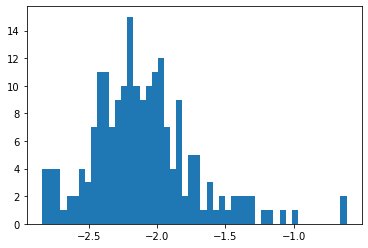

In [9]:
plt.hist(samples[:,0], bins=50)